In [1]:
from scipy.stats import wasserstein_distance
import os, ot
os.chdir('../')
from root_dir import * 
import pandas as pd
import numpy as np
from functools import partial

In [2]:
seed = 123
file_path = '%s/privateDemographics/data/toy/%s_outlierflag.csv' % (root_dir, 'train')
csv_df = pd.read_csv(file_path)
drop_idx = np.random.choice(csv_df[(csv_df.a == 2) & (csv_df.y == 1)].index, size = 16, replace = False)
csv_df = csv_df.drop(index = drop_idx)
kept_idx = csv_df.index
csv_df = csv_df.reset_index(drop = True)
df = [csv_df[csv_df.y == 0].reset_index(drop = True), csv_df[csv_df.y == 1].reset_index(drop = True)]
regular_set = [df[0][df[0].a != 1].index, df[1][df[1].a != 1].index]
outlier_set = [df[0][df[0].a == 1].index, df[1][df[1].a == 1].index]
n_regular, n_outlier = np.array([len(regular_set[0]), len(regular_set[1])]), np.array([len(outlier_set[0]), len(outlier_set[1])])
n = n_regular + n_outlier
orig_data = [df[0][['x1', 'x2', 'y']].values, df[1][['x1', 'x2', 'y']].values]
orig_weight = [np.ones((n[0],))/n[0], np.ones((n[1],))/n[1]]


In [20]:
n_outlier

array([55, 62])

# Extract gradients

In [3]:
from methods import *
from datasets import toyData

In [4]:
dataset_name = 'toy'

# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    outlier = 1,
    load_representations = True,
    start_model_path = f'{root_dir}/privateDemographics/models/toy/erm_num_epoch_100_batch_size_128_lr_0.01_subsample_0_weight_decay_0.0001_outlier_0_model_logreg_best.model',
    seed = 123,
    method = 'grass',
    device = torch.device('cpu'),
    lr = 1e-3,
    weight_decay = 1e-5,
    model = '',
)

grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 1,
)

Loading the toy dataset with outlier = 1!
Loaded all the gradient information into folder /skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/privateDemographics/results/toy/outliers...


In [5]:
orig_grad = [
    grad[kept_idx][idx_mode[kept_idx] == 'train'][csv_df.y == 0], 
    grad[kept_idx][idx_mode[kept_idx] == 'train'][csv_df.y == 1]
]

n = n_regular + n_outlier

# 1-Wasserstein Distance

In [6]:
y = 0

In [7]:
np.random.seed(seed)
plot1_regular = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_regular[y])
    for i, idx in enumerate(regular_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot1_regular[weight] = dist.mean()
    
plot1_outlier = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_outlier[y])
    for i, idx in enumerate(outlier_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot1_outlier[weight] = dist.mean()
    
plot1 = pd.DataFrame([pd.Series(plot1_regular), pd.Series(plot1_outlier)]).T
plot1 = plot1.reset_index()
plot1.columns = ['weight','other', 'minority']

Text(0, 0.5, '1-Wasserstein Distance')

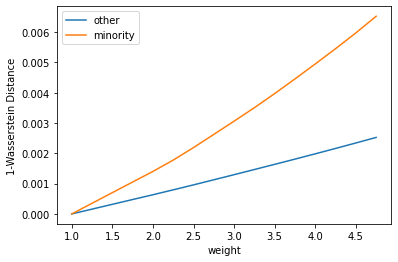

In [8]:
plot1.to_csv('%s/privateDemographics/results/toy/minority/W1ball_grad_y_%d.csv' % (root_dir, y)) 
ax = plot1.plot('weight', 'other')
plot1.plot('weight', 'minority', ax = ax)
ax.set_ylabel('1-Wasserstein Distance')

In [9]:
y = 1

In [10]:
np.random.seed(seed)
plot1_regular = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_regular[y])
    for i, idx in enumerate(regular_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot1_regular[weight] = dist.mean()
    
plot1_outlier = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_outlier[y])
    for i, idx in enumerate(outlier_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot1_outlier[weight] = dist.mean()
    
plot1 = pd.DataFrame([pd.Series(plot1_regular), pd.Series(plot1_outlier)]).T
plot1 = plot1.reset_index()
plot1.columns = ['weight','other', 'minority']

Text(0, 0.5, '1-Wasserstein Distance')

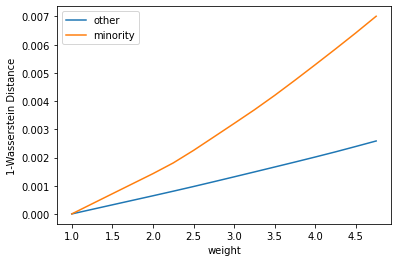

In [11]:
plot1.to_csv('%s/privateDemographics/results/toy/minority/W1ball_grad_y_%d.csv' % (root_dir, y)) 
ax = plot1.plot('weight', 'other')
plot1.plot('weight', 'minority', ax = ax)
ax.set_ylabel('1-Wasserstein Distance')

# 2-Wasserstein Distance

In [12]:
y = 0

In [13]:
np.random.seed(seed)
plot2_regular = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_regular[y])
    for i, idx in enumerate(regular_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])**2
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot2_regular[weight] = dist.mean()
    
plot2_outlier = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_outlier[y])
    for i, idx in enumerate(outlier_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])**2
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot2_outlier[weight] = dist.mean()
    
plot2 = pd.DataFrame([pd.Series(plot2_regular), pd.Series(plot2_outlier)]).T
plot2 = plot2.reset_index()
plot2.columns = ['weight','other', 'minority']

In [14]:
plot2.other = plot2.other**.5
plot2.minority = plot2.minority**.5

Text(0, 0.5, '2-Wasserstein Distance')

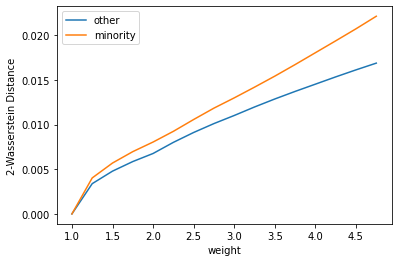

In [15]:
plot2.to_csv('%s/privateDemographics/results/toy/minority/W2ball_grad_y_%d.csv' % (root_dir, y)) 
ax = plot2.plot('weight', 'other')
plot2.plot('weight', 'minority', ax = ax)
ax.set_ylabel('2-Wasserstein Distance')

In [16]:
y = 1

In [17]:
np.random.seed(seed)
plot2_regular = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_regular[y])
    for i, idx in enumerate(regular_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])**2
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot2_regular[weight] = dist.mean()
    
plot2_outlier = {1: 0}
for weight in np.arange(1.25, 5, .25):
    dist = np.zeros(n_outlier[y])
    for i, idx in enumerate(outlier_set[y]):
        new_weight = np.ones((n[y],))
        new_weight[idx] = weight
        new_weight = new_weight / new_weight.sum()
        M = ot.dist(orig_grad[y], orig_grad[y])**2
        # new_grad = orig_grad[np.random.choice(np.arange(n), n, p = new_weight)]
        dist[i] = ot.emd2(orig_weight[y], new_weight, M)
    plot2_outlier[weight] = dist.mean()
    
plot2 = pd.DataFrame([pd.Series(plot2_regular), pd.Series(plot2_outlier)]).T
plot2 = plot2.reset_index()
plot2.columns = ['weight','other', 'minority']

In [18]:
plot2.other = plot2.other**.5
plot2.minority = plot2.minority**.5

Text(0, 0.5, '2-Wasserstein Distance')

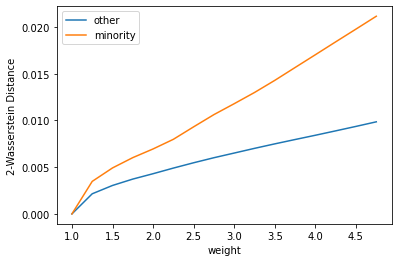

In [19]:
plot2.to_csv('%s/privateDemographics/results/toy/minority/W2ball_grad_y_%d.csv' % (root_dir, y)) 
ax = plot2.plot('weight', 'other')
plot2.plot('weight', 'minority', ax = ax)
ax.set_ylabel('2-Wasserstein Distance')